In [1]:
import re
import wandb
import pandas as pd
import numpy as np
import json

pd.set_option('display.max_rows', 48)
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 1000)

api = wandb.Api()
runs = api.runs("rap1ide/slice_inflate")

In [2]:
def get_agg_dict(filtered_frame):
    agg_dict = {
        n: 'first' if t != float else 'mean' for n,t in zip(filtered_frame.columns,filtered_frame.dtypes)
    }
    return agg_dict

# get n chunks of a list
def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def join_cols(frame, first_col_key, second_col_key, join_str="+", drop_second=True):
    first_col = frame[first_col_key].astype(str)
    second_col = frame[second_col_key].astype(str)
    frame[first_col_key] = first_col + join_str + second_col

    if drop_second:
        frame.drop(second_col_key, axis=1, inplace=True)
    else:
        frame.drop(first_col_key, axis=1, inplace=True)
    return frame

# Ablation experiment

In [7]:
SETTINGS = {
   "0:1": dict(description="Clinical standard",
      first_view="p2CH",
      second_view="p4CH",
      prescan_res ="$(1.5mm)^3$",
      prescan_type ="GT",
      slice_res ="$(1.5mm)^2$",
      slice_type="GT",
   ),
   "1:2": dict(description="Clinical standard",
      first_view="2CH",
      second_view="4CH",
      prescan_res ="$(1.5mm)^3$",
      prescan_type ="GT",
      slice_res ="$(1.5mm)^2$",
      slice_type="GT",
   ),
   "2:3": dict(description="Clinical standard",
      first_view="2CH",
      second_view="SA",
      prescan_res ="$(1.5mm)^3$",
      prescan_type ="GT",
      slice_res ="$(1.5mm)^2$",
      slice_type="GT",
   ),
   "3:9": dict(description="Mean out of 6 Random",
      first_view="RND",
      second_view="RND",
      prescan_res ="$(1.5mm)^3$",
      prescan_type ="GT",
      slice_res ="$(1.5mm)^2$",
      slice_type="GT",
   ),
   "9:10": dict(description="Optimized",
      first_view=">OPT<",
      second_view=">OPT<",
      prescan_res ="$(1.5mm)^3$",
      prescan_type ="GT",
      slice_res ="$(1.5mm)^2$",
      slice_type="GT",
   ),

   "10:11": dict(description="Clinical standard",
      first_view="2CH",
      second_view="4CH",
      prescan_res ="$(6mm)^3$",
      prescan_type ="GT",
      slice_res ="$(1.5mm)^2$",
      slice_type="GT",
   ),
   "11:12": dict(description="Optimized",
      first_view=">OPT<",
      second_view=">OPT<",
      prescan_res ="$(6mm)^3$",
      prescan_type ="GT",
      slice_res ="$(1.5mm)^2$",
      slice_type="GT",
   ),

   "12:13": dict(description="Clinical standard",
      first_view="2CH",
      second_view="4CH",
      prescan_res ="$(6mm)^3$",
      prescan_type ="SEG",
      slice_res ="$(1.5mm)^2$",
      slice_type="SEG",
   ),
   "13:14": dict(description="Optimized",
      first_view=">OPT<",
      second_view=">OPT<",
      prescan_res ="$(6mm)^3$",
      prescan_type ="SEG",
      slice_res ="$(1.5mm)^2$",
      slice_type="SEG",
   ),

   "14:15": dict(description="Clinical standard",
      first_view="2CH",
      second_view="4CH",
      prescan_res ="$(6mm)^3$",
      prescan_type ="SEG",
      slice_res ="$(6mm)^3$",
      slice_type="SEG",
   ),
   "15:16": dict(description="Optimized",
      first_view=">OPT<",
      second_view=">OPT<",
      prescan_res ="$(6mm)^3$",
      prescan_type ="SEG",
      slice_res ="$(6mm)^3$",
      slice_type="SEG",
   ),
}

In [3]:
def get_wanted_keys(phase):
    assert phase in ['val', 'test']

    wanted_keys = {
        '_id': '_id',
        'prescan_res': 'Scout res.',
        # 'description': 'Description',
        'prescan_type': 'Scout label',
        'slice_res': 'Slice res.',
        'slice_type': 'Slice label',
        'first_view': '1st view',
        'second_view': '2nd view',
        'fold': 'fold',

        f'scores/{phase}_mean_hd95_MYO': 'MYO',
        f'scores/{phase}_mean_hd95_LV': 'LV',
        f'scores/{phase}_mean_hd95_RV': 'RV',
        f'scores/{phase}_mean_hd95_LA': 'LA',
        f'scores/{phase}_mean_hd95_RA': 'RA',
        f'scores/{phase}_mean_oa_exclude_bg_hd95': '\multicolumn{1}{c}{$\mu\pm\sigma$  }',
        f'scores/{phase}_std_oa_exclude_bg_hd95': 'N/A',

        f'scores/{phase}_mean_dice_MYO': 'MYO',
        f'scores/{phase}_mean_dice_LV': 'LV',
        f'scores/{phase}_mean_dice_RV': 'RV',
        f'scores/{phase}_mean_dice_LA': 'LA',
        f'scores/{phase}_mean_dice_RA': 'RA',
        f'scores/{phase}_mean_oa_exclude_bg_dice': '\multicolumn{1}{c}{$\mu\pm\sigma$ }',
        f'scores/{phase}_std_oa_exclude_bg_dice': 'N/A',

        # 'scores/val_mean_oa_exclude_bg_iou': 'IOU',
        # 'scores/val_std_oa_exclude_bg_iou': '',

        f'scores/{phase}_mean_delta_vol_rel_LV': '\multicolumn{1}{c}{$\mu\pm\sigma$}   ',
        f'scores/{phase}_std_delta_vol_rel_LV': '',
    }
    return wanted_keys

In [4]:
recent_mmwhs_runs = list(filter(lambda r:
                          r.name.startswith("202402")
                          and 'meta_config_id' in r.config
                          and isinstance(r.config['meta_config_id'], int)
                          and r.config['dataset'][0] == 'mmwhs', runs))

mmwhs_runs = [dict(name=f"dummy{idx:02d}") for idx in range(0,48)]

for run_idx in range(len(mmwhs_runs)):
    meta_config_id = int(run_idx // 3)
    fold_idx = run_idx % 3
    if meta_config_id in [9,11,13,15]:
        wandb_runs = list(filter(lambda r: f"fold-{fold_idx}" in r.name
            and 'meta_config_id' in r.config
            and r.config['meta_config_id'] == meta_config_id
            and '-opt_both_fix' in r.name,
            recent_mmwhs_runs))
    else:
        wandb_runs = list(filter(lambda r: f"fold-{fold_idx}" in r.name
            and 'meta_config_id' in r.config
            and r.config['meta_config_id'] == meta_config_id
            and '-ref' in r.name,
            recent_mmwhs_runs))

    if len(wandb_runs) > 1:
        raise ValueError(f"Expected exactly one run, got {len(wandb_runs)}")
    elif len(wandb_runs) == 0:
        continue

    run = wandb_runs[0]
    name = run.name
    path = run.path
    meta_config_id = run.config['meta_config_id']

    fold_idx = int(re.match(r'.*fold-(\d+).*', name).group(1))
    entry = dict(
        name=name,
        id=meta_config_id,
        fold=fold_idx,
        access_key='/'.join(path),
    )
    mmwhs_runs[run_idx] = entry

with open('mmwhs_runs.json', 'w') as f:
    json.dump(mmwhs_runs, f, indent=4)

# Build latex tables

## Build latex table for MMWHS

In [6]:
PHASE = 'val'
VALUE_SELECTOR = 'select_last'

df = pd.DataFrame()

for run_idx, rr in enumerate(mmwhs_runs):
   wandb_run_name = rr['name']
   run_frame = pd.DataFrame()
   run_numeric_id = run_idx // 3
   try:
      run_key = rr['access_key']
      wrun = api.run(run_key)
      run_frame = pd.DataFrame(wrun.history())
      if VALUE_SELECTOR == 'select_best':
         max_idx = run_frame[f'scores/{PHASE}_mean_oa_exclude_bg_dice'].idxmax()
         run_frame = run_frame.fillna(method='ffill')
         run_frame = run_frame.iloc[max_idx:max_idx+1]
      elif VALUE_SELECTOR == 'select_last':
         run_frame = run_frame.iloc[-1:]
      else:
         raise ValueError()

      run_frame.index = [run_idx]

   except:
      print(f"Failed to fetch run {wandb_run_name}")
      run_frame = run_frame.map(lambda x: np.nan)

   if 3 <= run_numeric_id < 9:
      run_settings = SETTINGS['3:9']
   else:
      run_settings = SETTINGS[f"{run_numeric_id}:{run_numeric_id+1}"]

   run_frame.insert(0, '_id', [run_numeric_id])
   run_frame.insert(1, 'description', [run_settings['description']])
   run_frame.insert(2, 'first_view', run_settings['first_view'])
   run_frame.insert(3, 'second_view', run_settings['second_view'])
   run_frame.insert(4, 'prescan_res', run_settings['prescan_res'])
   run_frame.insert(5, 'prescan_type', run_settings['prescan_type'])
   run_frame.insert(6, 'slice_res', run_settings['slice_res'])
   run_frame.insert(7, 'slice_type', run_settings['slice_type'])
   fold_idx = run_idx % 3
   run_frame.insert(8, 'fold', fold_idx)

   df = pd.concat([df,run_frame])

df = df.fillna(0)

In [7]:
filtered_frame = df.copy()
FIRST_FOLD_ONLY = True
if FIRST_FOLD_ONLY:
    filtered_frame = filtered_frame[filtered_frame['fold'] == 0]
else:
    filtered_frame = filtered_frame.groupby('_id').agg(get_agg_dict(filtered_frame))

# Prepare values
wanted_keys = get_wanted_keys('val')
filtered_frame = filtered_frame[wanted_keys.keys()]
filtered_frame

,_id,prescan_res,prescan_type,slice_res,slice_type,first_view,second_view,fold,scores/val_mean_hd95_MYO,scores/val_mean_hd95_LV,...,scores/val_std_oa_exclude_bg_hd95,scores/val_mean_dice_MYO,scores/val_mean_dice_LV,scores/val_mean_dice_RV,scores/val_mean_dice_LA,scores/val_mean_dice_RA,scores/val_mean_oa_exclude_bg_dice,scores/val_std_oa_exclude_bg_dice,scores/val_mean_delta_vol_rel_LV,scores/val_std_delta_vol_rel_LV
0,0,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,p2CH,p4CH,0,7.653829,8.184327,...,25.385578,0.787386,0.882927,0.694416,0.756825,0.653961,0.755103,0.161880,0.165246,0.148523
3,1,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,2CH,4CH,0,6.848581,8.203704,...,10.160501,0.818286,0.886840,0.771518,0.864691,0.748848,0.818037,0.094747,0.170663,0.193362
6,2,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,2CH,SA,0,7.778636,10.233290,...,10.033892,0.799069,0.876908,0.770499,0.797110,0.613154,0.771348,0.121211,0.143610,0.107447
9,3,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,RND,RND,0,10.942106,13.641310,...,5.689139,0.734541,0.835747,0.838065,0.841880,0.738294,0.797705,0.081127,0.276734,0.306709
12,4,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,RND,RND,0,11.198994,13.932410,...,5.608179,0.668667,0.809187,0.830045,0.806202,0.714641,0.765748,0.092047,0.332480,0.412373
15,5,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,RND,RND,0,12.473555,14.390116,...,5.549861,0.679266,0.814930,0.839961,0.833424,0.716549,0.776826,0.090776,0.278786,0.287378
18,6,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,RND,RND,0,11.047014,12.633115,...,6.948728,0.747566,0.843451,0.760267,0.692075,0.843542,0.777380,0.092904,0.283455,0.304741
21,7,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,RND,RND,0,13.699623,13.779130,...,30.877003,0.678732,0.819600,0.744619,0.727265,0.794291,0.752901,0.102870,0.296043,0.357756
24,8,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,RND,RND,0,12.886364,14.939037,...,5.558770,0.651022,0.802227,0.811667,0.779799,0.725570,0.754057,0.093950,0.357191,0.400342
27,9,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,>OPT<,>OPT<,0,8.635031,9.707458,...,3.890873,0.796883,0.878357,0.798217,0.811366,0.849726,0.826910,0.065265,0.157118,0.184553


In [8]:
percent_keys = [k for k in wanted_keys if "dice" in k or "vol_rel" in k]
mean_keys = [k for k in wanted_keys if "mean" in k]
min_metrics_keys = [k for k in wanted_keys if ("delta" in k or "hd" in k) and not 'std' in k]
max_metrics_keys = [k for k in wanted_keys if ("dice" in k or "iou" in k) and not 'std' in k]
filtered_frame.loc[:,percent_keys] *= 100.

# Aggregate random runs to build mean
random_runs = list(range(0,3)) + 6 * ['is_random'] + list(range(9,16))
filtered_frame.insert(1, 'is_random', random_runs)
filtered_frame = filtered_frame.groupby('is_random', as_index=False).agg(get_agg_dict(filtered_frame))

reindex_idx = list(range(0,3)) + [-1] + list(range(3,10))
filtered_frame = filtered_frame.iloc[reindex_idx,:]
filtered_frame.drop('is_random', axis=1, inplace=True)

filtered_frame

,_id,prescan_res,prescan_type,slice_res,slice_type,first_view,second_view,fold,scores/val_mean_hd95_MYO,scores/val_mean_hd95_LV,...,scores/val_std_oa_exclude_bg_hd95,scores/val_mean_dice_MYO,scores/val_mean_dice_LV,scores/val_mean_dice_RV,scores/val_mean_dice_LA,scores/val_mean_dice_RA,scores/val_mean_oa_exclude_bg_dice,scores/val_std_oa_exclude_bg_dice,scores/val_mean_delta_vol_rel_LV,scores/val_std_delta_vol_rel_LV
0,0,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,p2CH,p4CH,0,7.653829,8.184327,...,25.385578,78.738603,88.292696,69.441575,75.682512,65.396118,75.510301,16.188044,16.524597,14.852262
1,1,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,2CH,4CH,0,6.848581,8.203704,...,10.160501,81.828588,88.684019,77.151842,86.469139,74.884791,81.803676,9.474719,17.066317,19.336211
2,2,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,2CH,SA,0,7.778636,10.233290,...,10.033892,79.906897,87.690754,77.049935,79.711009,61.315411,77.134801,12.121097,14.360977,10.744652
10,3,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,RND,RND,0,12.041276,13.885853,...,10.038613,69.329900,82.085699,80.410421,78.010756,75.548112,77.076978,9.227907,30.411486,34.488311
3,9,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,>OPT<,>OPT<,0,8.635031,9.707458,...,3.890873,79.688274,87.835688,79.821746,81.136646,84.972610,82.690993,6.526484,15.711795,18.455316
4,10,$(6mm)^3$,GT,$(1.5mm)^2$,GT,2CH,4CH,0,7.543268,8.092771,...,9.240935,81.008878,89.431286,78.905762,85.206588,76.383987,82.187300,8.628087,13.829095,11.850469
5,11,$(6mm)^3$,GT,$(1.5mm)^2$,GT,>OPT<,>OPT<,0,8.884485,10.234073,...,7.179926,77.132856,86.147490,80.978002,81.338496,81.078799,81.335129,9.302832,21.037749,31.941642
6,12,$(6mm)^3$,SEG,$(1.5mm)^2$,SEG,2CH,4CH,0,17.105310,19.101296,...,50.733008,56.248964,71.550042,56.310090,35.215080,38.840810,51.632997,25.201866,34.144068,61.759994
7,13,$(6mm)^3$,SEG,$(1.5mm)^2$,SEG,>OPT<,>OPT<,0,35.043650,32.705315,...,23.366004,43.799849,68.960303,56.545906,39.583003,61.250282,54.027869,19.603067,38.343801,36.482585
8,14,$(6mm)^3$,SEG,$(6mm)^3$,SEG,2CH,4CH,0,42.789312,35.606248,...,41.012343,43.645044,63.402015,46.557217,42.056451,39.684406,47.069027,21.403570,50.757395,47.617735


In [9]:
# # MMWHS Prescan 6 mm seg properties mean over all dataset samples
# dataset/prescan_mean_dice_MYO 0.723
# dataset/prescan_mean_dice_LV 0.876
# dataset/prescan_mean_dice_RV 0.817
# dataset/prescan_mean_dice_LA 0.800
# dataset/prescan_mean_dice_RA 0.810

# dataset/prescan_mean_hd95_MYO 10.838
# dataset/prescan_mean_hd95_LV 12.802
# dataset/prescan_mean_hd95_RV 16.291
# dataset/prescan_mean_hd95_LA 12.822
# dataset/prescan_mean_hd95_RA 13.034

# dataset/prescan_mean_dice_MYO 0.050
# dataset/prescan_mean_dice_LV 0.037
# dataset/prescan_mean_dice_RV 0.088
# dataset/prescan_mean_dice_LA 0.069
# dataset/prescan_mean_dice_RA 0.122

# dataset/prescan_mean_hd95_MYO 10.406
# dataset/prescan_mean_hd95_LV 15.017
# dataset/prescan_mean_hd95_RV 15.628
# dataset/prescan_mean_hd95_LA 4.776
# dataset/prescan_mean_hd95_RA 6.819

# dataset/prescan_mean_oa_exclude_bg_dice 0.805
# dataset/prescan_mean_oa_exclude_bg_dice 0.093

# dataset/prescan_mean_oa_exclude_bg_hd95 13.158
# dataset/prescan_mean_oa_exclude_bg_hd95 11.513

mmwhs_prescan_metrics = np.array(
       [
              11.5, '$(6mm)^3$', 'SEG', 'N/A', 'N/A', 'N/A', 'N/A', -1,
              10.838, 12.802, 16.291, 12.822, 13.034, 13.158, 11.513,
              72.3, 87.6, 81.7, 80.0, 81.0, 80.5, 9.3,
              -1., -1.
       ], dtype=object
)

filtered_frame.loc[len(filtered_frame)] = pd.Series(dtype=object)
filtered_frame.iloc[-1] = mmwhs_prescan_metrics

# Now sort _id column ascending
filtered_frame = filtered_frame.sort_values('_id')
filtered_frame.index = list(range(len(filtered_frame)))

In [10]:
# Get bold values (best)
group_ranges = [
    [0,5],
    [5,7],
    [8,10],
    [10,12],
]

bold_idxs = []
for sub_range in group_ranges:
    sub_frame = filtered_frame.iloc[sub_range[0]:sub_range[1]]
    optimal_vals_maximize = sub_frame[max_metrics_keys].idxmax()
    optimal_vals_minimize = sub_frame[min_metrics_keys].idxmin()

    bold_idxs.append(optimal_vals_maximize)
    bold_idxs.append(optimal_vals_minimize)

In [11]:
# Round and convert
filtered_frame = filtered_frame.round(decimals=1)
string_frame = filtered_frame.copy().astype(str)

# Fuse mean and std columns
for m in mean_keys:
    mean_col = string_frame[m].astype(str)
    std_col_key = m.replace("mean","std")
    if std_col_key in string_frame.columns:
        std_col = string_frame[std_col_key].astype(str)
        string_frame[m] = mean_col + r" \pm " + std_col
        string_frame.drop(std_col_key, axis=1, inplace=True)

# Add bold to optimal values
for bold_group in bold_idxs:
    for col_name, idx in zip(bold_group.index, bold_group.values):
        row_idx = string_frame.index.get_loc(idx)
        col_idx = string_frame.columns.get_loc(col_name)
        string_frame.iloc[row_idx,col_idx] = r"\B " + string_frame.iloc[row_idx,col_idx]

# Join first and second view
# string_frame = join_cols(string_frame, 'first_view', 'second_view', join_str=r"+")
# string_frame = join_cols(string_frame, 'prescan_type', 'prescan_res', join_str=r" ", drop_second=True)
# string_frame = join_cols(string_frame, 'slice_type', 'slice_res', join_str=r" ", drop_second=True)

# Replace column names
string_frame.columns = [wanted_keys[c] for c in string_frame.columns]

# Drop and insert spacer columns
string_frame.drop('_id', axis=1, inplace=True)
string_frame.drop('fold', axis=1, inplace=True)

# Add braces to metrics of prescan
for col_idx in range(6, len(string_frame.columns)):
    string_frame.iloc[7,col_idx] = r"\BR{" + string_frame.iloc[7,col_idx] + r"}"

string_frame.insert(6, ' ', len(string_frame)*["\hspace{1pt}"])
string_frame.insert(13, '  ', len(string_frame)*["\hspace{1pt}"])
string_frame.insert(20, '   ', len(string_frame)*["\hspace{1pt}"])

# Add offset to groups in latex
for group_idxs in group_ranges[:-1]:
    txt = string_frame.iloc[group_idxs[1],0]
    string_frame.iloc[group_idxs[1],0] = r"\rule{0pt}{4ex} "+txt

# Drop last two rows and columns
string_frame = string_frame.iloc[:-2,:-2]

new_rows_descriptors = [
    r"$1.5mm^3$ GT --- $1.5mm^2$ GT",
    r"$1.5mm^3$ GT --- $1.5mm^2$ GT",
    r"$1.5mm^3$ GT --- $1.5mm^2$ GT",
    r"$1.5mm^3$ GT --- $1.5mm^2$ GT",
    r"$1.5mm^3$ GT --- $1.5mm^2$ GT",
    r"$6.0mm^3$ GT --- $1.5mm^2$ GT\rule{0pt}{4ex}",
    r"$6.0mm^3$ GT --- $1.5mm^2$ GT",
    r"$6.0mm^3$ SG\rule{0pt}{4ex}",
    r"$6.0mm^3$ SG --- $1.5mm^2$ SG",
    r"$6.0mm^3$ SG --- $1.5mm^2$ SG",
]
string_frame.insert(0, 'Type of: scout --- slices', new_rows_descriptors)
string_frame = string_frame.drop(["Scout res.", "Scout label", "Slice res.", "Slice label"], axis=1)

In [12]:
# Save to latex

PM_COL_FORMAT = "S[table-figures-decimal=1,separate-uncertainty=true,table-format=3.1(3)]"
# COL_FORMAT = \
#     ("c" * 12) \
#     + PM_COL_FORMAT \
#     + ("c" * 6) \
#     + PM_COL_FORMAT \
#     # + "c" \
#     # + PM_COL_FORMAT
COL_FORMAT = \
    "l" \
    + ("c" * 8) \
    + PM_COL_FORMAT \
    + ("c" * 6) \
    + PM_COL_FORMAT \
    # + "c" \
    # + PM_COL_FORMAT
# 19 cols

# header = [
#     r'\multicolumn{6}{c}{\textbf{Experiment I}}'] \
#     + 5*[None] \
#     + [r'\hspace{1pt}'] \
#     + [r'\multicolumn{6}{c}{\textbf{HD95 in mm $\downarrow$}}'] + 5*[None] \
#     + [r'\hspace{1pt}'] \
#     + [r'\multicolumn{6}{c}{\textbf{Dice in \% $\uparrow$}}'] + 5*[None] \
#     # + [r'\hspace{1pt}'] \

header = [
    r'\multicolumn{3}{l}{\textbf{Clinically acquired MMWHS data}}'] \
    + 2*[None] \
    + [r'\hspace{1pt}'] \
    + [r'\multicolumn{6}{c}{\textbf{HD95 in mm $\downarrow$}}'] + 5*[None] \
    + [r'\hspace{1pt}'] \
    + [r'\multicolumn{6}{c}{\textbf{Dice in \% $\uparrow$}}'] + 5*[None] \
    # + [r'\hspace{1pt}'] \
    # + [r'\textbf{$\Delta$vol LV in \% $\downarrow$}']

latex_frame = pd.concat([pd.DataFrame(header, index=string_frame.columns).T, string_frame])

latex_frame.to_latex(
    buf="mmwhs_results.txt",
    escape=False,
    column_format=COL_FORMAT,
    index=False,
)

# Load latex file and replace & NaN with &
with open("mmwhs_results.txt", "r") as f:
    lines = f.readlines()
    lines = [l.replace("Scout res. & Scout label", r'\multicolumn{2}{c}{Scout res./label}') for l in lines]
    lines = [l.replace("Slice res. & Slice label", r'\multicolumn{2}{c}{Slice res./label}') for l in lines]
    lines = [l.replace("& NaN", "") for l in lines]

with open("mmwhs_results.txt", "w") as f:
    f.writelines(lines)

# Insert 5th line before third line
with open("mmwhs_results.txt", "r") as f:
    lines = f.readlines()
    lines.insert(2, lines[4])
    del lines[5]
with open("mmwhs_results.txt", "w") as f:
    f.writelines(lines)

# Build latex table for MRXCAT

In [13]:
recent_mrxcat_runs = list(filter(lambda r:
                          r.name.startswith("202402")
                          and 'meta_config_id' in r.config
                          and isinstance(r.config['meta_config_id'], int)
                          and r.config['dataset'][0] == 'mrxcat', runs))

mrxcat_runs = [dict(name=f"dummy{idx:02d}") for idx in range(0,16)]

for run_idx in range(len(mrxcat_runs)):
    meta_config_id = run_idx
    fold_idx = 0
    if meta_config_id in [9,11,13,15]:
        wandb_runs = list(filter(lambda r: f"fold-{fold_idx}" in r.name
            and 'meta_config_id' in r.config
            and r.config['meta_config_id'] == meta_config_id
            and '-opt_both_fix' in r.name,
            recent_mrxcat_runs))
    else:
        wandb_runs = list(filter(lambda r: f"fold-{fold_idx}" in r.name
            and 'meta_config_id' in r.config
            and r.config['meta_config_id'] == meta_config_id
            and '-ref' in r.name,
            recent_mrxcat_runs))

    if len(wandb_runs) > 1:
        raise ValueError(f"Expected exactly one run, got {len(wandb_runs)}")
    elif len(wandb_runs) == 0:
        continue

    run = wandb_runs[0]
    name = run.name
    path = run.path
    meta_config_id = run.config['meta_config_id']

    fold_idx = int(re.match(r'.*fold-(\d+).*', name).group(1))
    entry = dict(
        name=name,
        id=meta_config_id,
        fold=fold_idx,
        access_key='/'.join(path),
    )
    mrxcat_runs[run_idx] = entry

with open('mrxcat_runs.json', 'w') as f:
    json.dump(mrxcat_runs, f, indent=4)

In [14]:
PHASE = 'test'
VALUE_SELECTOR = 'select_last'

df = pd.DataFrame()

for run_idx, rr in enumerate(mrxcat_runs):
   wandb_run_name = rr['name']
   run_frame = pd.DataFrame()
   run_numeric_id = run_idx
   try:
      run_key = rr['access_key']
      wrun = api.run(run_key)
      run_frame = pd.DataFrame(wrun.history())
      if VALUE_SELECTOR == 'select_best':
         max_idx = run_frame[f'scores/{PHASE}_mean_oa_exclude_bg_dice'].idxmax()
         run_frame = run_frame.fillna(method='ffill')
         run_frame = run_frame.iloc[max_idx:max_idx+1]
      elif VALUE_SELECTOR == 'select_last':
         run_frame = run_frame.iloc[-1:]
      else:
         raise ValueError()

      run_frame.index = [run_idx]

   except:
      print(f"Failed to fetch run {wandb_run_name}")
      run_frame = run_frame.map(lambda x: np.nan)

   if 3 <= run_numeric_id < 9:
      run_settings = SETTINGS['3:9']
   else:
      run_settings = SETTINGS[f"{run_numeric_id}:{run_numeric_id+1}"]

   run_frame.insert(0, '_id', [run_numeric_id])
   run_frame.insert(1, 'description', [run_settings['description']])
   run_frame.insert(2, 'first_view', run_settings['first_view'])
   run_frame.insert(3, 'second_view', run_settings['second_view'])
   run_frame.insert(4, 'prescan_res', run_settings['prescan_res'])
   run_frame.insert(5, 'prescan_type', run_settings['prescan_type'])
   run_frame.insert(6, 'slice_res', run_settings['slice_res'])
   run_frame.insert(7, 'slice_type', run_settings['slice_type'])
   fold_idx = run_idx % 3
   run_frame.insert(8, 'fold', fold_idx)

   df = pd.concat([df,run_frame])

df = df.fillna(0)

In [15]:
filtered_frame = df.copy()
filtered_frame = filtered_frame.groupby('_id').agg(get_agg_dict(filtered_frame))

wanted_keys = get_wanted_keys('test') # Use test here for MRXCAT

In [16]:
# Prepare values
filtered_frame = filtered_frame[wanted_keys.keys()]

percent_keys = [k for k in wanted_keys if "dice" in k or "vol_rel" in k]
mean_keys = [k for k in wanted_keys if "mean" in k]
min_metrics_keys = [k for k in wanted_keys if ("delta" in k or "hd" in k) and not 'std' in k]
max_metrics_keys = [k for k in wanted_keys if ("dice" in k or "iou" in k) and not 'std' in k]
filtered_frame.loc[:,percent_keys] *= 100.

# Aggregate random runs to build mean
random_runs = list(range(0,3)) + 6 * ['is_random'] + list(range(9,16))
filtered_frame.insert(1, 'is_random', random_runs)
filtered_frame = filtered_frame.groupby('is_random', as_index=False).agg(get_agg_dict(filtered_frame))

reindex_idx = list(range(0,3)) + [-1] + list(range(3,10))
filtered_frame = filtered_frame.iloc[reindex_idx,:]
filtered_frame.drop('is_random', axis=1, inplace=True)

filtered_frame

,_id,prescan_res,prescan_type,slice_res,slice_type,first_view,second_view,fold,scores/test_mean_hd95_MYO,scores/test_mean_hd95_LV,...,scores/test_std_oa_exclude_bg_hd95,scores/test_mean_dice_MYO,scores/test_mean_dice_LV,scores/test_mean_dice_RV,scores/test_mean_dice_LA,scores/test_mean_dice_RA,scores/test_mean_oa_exclude_bg_dice,scores/test_std_oa_exclude_bg_dice,scores/test_mean_delta_vol_rel_LV,scores/test_std_delta_vol_rel_LV
0,0,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,p2CH,p4CH,0,6.216542,5.278699,...,14.723121,82.365680,89.962780,84.246920,90.587256,83.423031,86.117134,8.480595,19.395498,14.357763
1,1,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,2CH,4CH,1,6.535374,7.082328,...,1.995381,79.869457,86.764754,83.489179,90.705665,85.219574,85.209726,5.884246,30.629576,19.055006
2,2,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,2CH,SA,2,6.525092,7.173643,...,2.624240,79.310299,86.509711,83.911880,88.602206,82.869542,84.240728,6.231887,31.524916,23.117174
10,3,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,RND,RND,0,7.231893,8.436540,...,5.368297,78.885249,86.323227,84.887841,87.146353,88.570580,85.162650,6.984976,30.909936,21.359366
3,9,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,>OPT<,>OPT<,0,6.275527,6.618766,...,1.970672,80.661790,87.785348,86.257728,91.045689,88.928367,86.935785,5.418078,27.282583,18.599704
4,10,$(6mm)^3$,GT,$(1.5mm)^2$,GT,2CH,4CH,1,6.342387,7.252972,...,2.976584,79.127998,86.909891,80.664413,91.304989,86.368576,84.875173,6.651285,29.929758,19.653570
5,11,$(6mm)^3$,GT,$(1.5mm)^2$,GT,>OPT<,>OPT<,2,6.760223,7.167126,...,1.815409,78.697366,85.706467,87.278667,88.749583,87.245049,85.535426,5.967787,33.093803,23.221983
6,12,$(6mm)^3$,SEG,$(1.5mm)^2$,SEG,2CH,4CH,0,10.341926,10.169448,...,17.400824,68.602278,82.099271,82.439385,85.958241,85.855292,80.990893,8.000468,42.286111,25.242616
7,13,$(6mm)^3$,SEG,$(1.5mm)^2$,SEG,>OPT<,>OPT<,1,9.377438,9.789072,...,2.971459,69.880948,81.774322,84.027920,76.426268,87.438237,79.909539,8.733575,44.103078,30.057787
8,14,$(6mm)^3$,SEG,$(6mm)^3$,SEG,2CH,4CH,2,9.901599,8.897509,...,1.971846,67.375544,81.567824,81.006334,86.536309,82.427823,79.782767,7.850007,45.228122,21.502644


In [17]:
# MRXCAT dataset metrics
# dataset/prescan_mean_dice_MYO 0.796
# dataset/prescan_mean_dice_LV 0.915
# dataset/prescan_mean_dice_RV 0.901
# dataset/prescan_mean_dice_LA 0.855
# dataset/prescan_mean_dice_RA 0.865

# dataset/prescan_mean_hd95_MYO 5.298
# dataset/prescan_mean_hd95_LV 5.266
# dataset/prescan_mean_hd95_RV 5.503
# dataset/prescan_mean_hd95_LA 5.579
# dataset/prescan_mean_hd95_RA 5.784

# dataset/prescan_mean_dice_MYO 0.015
# dataset/prescan_mean_dice_LV 0.002
# dataset/prescan_mean_dice_RV 0.003
# dataset/prescan_mean_dice_LA 0.007
# dataset/prescan_mean_dice_RA 0.006

# dataset/prescan_mean_hd95_MYO 0.229
# dataset/prescan_mean_hd95_LV 0.337
# dataset/prescan_mean_hd95_RV 0.307
# dataset/prescan_mean_hd95_LA 0.297
# dataset/prescan_mean_hd95_RA 0.123

# dataset/prescan_mean_oa_exclude_bg_dice 0.866
# dataset/prescan_mean_oa_exclude_bg_dice 0.042

# dataset/prescan_mean_oa_exclude_bg_hd95 5.486
# dataset/prescan_mean_oa_exclude_bg_hd95 0.330

mrxcat_prescan_metrics = np.array([
    11.5, '$(6mm)^3$', 'SEG', 'N/A', 'N/A', 'N/A', 'N/A', -1,
    5.298, 5.266, 5.503, 5.579, 5.784, 5.486, 0.330,
    79.6, 91.5, 90.1, 85.5, 86.5, 86.6, 4.2,
    -1., -1.], dtype=object)

filtered_frame.loc[len(filtered_frame)] = pd.Series(dtype=object)
filtered_frame.iloc[-1] = mrxcat_prescan_metrics

# Now sort _id column ascending
filtered_frame = filtered_frame.sort_values('_id')
filtered_frame.index = list(range(len(filtered_frame)))

In [18]:
# Get bold values (best)
group_ranges = [
    [0,5],
    [5,7],
    [8,10],
    [10,12],
]

bold_idxs = []
for sub_range in group_ranges:
    sub_frame = filtered_frame.iloc[sub_range[0]:sub_range[1]]
    optimal_vals_maximize = sub_frame[max_metrics_keys].idxmax()
    optimal_vals_minimize = sub_frame[min_metrics_keys].idxmin()

    bold_idxs.append(optimal_vals_maximize)
    bold_idxs.append(optimal_vals_minimize)
filtered_frame

,_id,prescan_res,prescan_type,slice_res,slice_type,first_view,second_view,fold,scores/test_mean_hd95_MYO,scores/test_mean_hd95_LV,...,scores/test_std_oa_exclude_bg_hd95,scores/test_mean_dice_MYO,scores/test_mean_dice_LV,scores/test_mean_dice_RV,scores/test_mean_dice_LA,scores/test_mean_dice_RA,scores/test_mean_oa_exclude_bg_dice,scores/test_std_oa_exclude_bg_dice,scores/test_mean_delta_vol_rel_LV,scores/test_std_delta_vol_rel_LV
0,0.0,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,p2CH,p4CH,0.0,6.216542,5.278699,...,14.723121,82.365680,89.962780,84.246920,90.587256,83.423031,86.117134,8.480595,19.395498,14.357763
1,1.0,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,2CH,4CH,1.0,6.535374,7.082328,...,1.995381,79.869457,86.764754,83.489179,90.705665,85.219574,85.209726,5.884246,30.629576,19.055006
2,2.0,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,2CH,SA,2.0,6.525092,7.173643,...,2.624240,79.310299,86.509711,83.911880,88.602206,82.869542,84.240728,6.231887,31.524916,23.117174
3,3.0,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,RND,RND,0.0,7.231893,8.436540,...,5.368297,78.885249,86.323227,84.887841,87.146353,88.570580,85.162650,6.984976,30.909936,21.359366
4,9.0,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,>OPT<,>OPT<,0.0,6.275527,6.618766,...,1.970672,80.661790,87.785348,86.257728,91.045689,88.928367,86.935785,5.418078,27.282583,18.599704
5,10.0,$(6mm)^3$,GT,$(1.5mm)^2$,GT,2CH,4CH,1.0,6.342387,7.252972,...,2.976584,79.127998,86.909891,80.664413,91.304989,86.368576,84.875173,6.651285,29.929758,19.653570
6,11.0,$(6mm)^3$,GT,$(1.5mm)^2$,GT,>OPT<,>OPT<,2.0,6.760223,7.167126,...,1.815409,78.697366,85.706467,87.278667,88.749583,87.245049,85.535426,5.967787,33.093803,23.221983
7,11.5,$(6mm)^3$,SEG,N/A,N/A,N/A,N/A,-1.0,5.298000,5.266000,...,0.330000,79.600000,91.500000,90.100000,85.500000,86.500000,86.600000,4.200000,-1.000000,-1.000000
8,12.0,$(6mm)^3$,SEG,$(1.5mm)^2$,SEG,2CH,4CH,0.0,10.341926,10.169448,...,17.400824,68.602278,82.099271,82.439385,85.958241,85.855292,80.990893,8.000468,42.286111,25.242616
9,13.0,$(6mm)^3$,SEG,$(1.5mm)^2$,SEG,>OPT<,>OPT<,1.0,9.377438,9.789072,...,2.971459,69.880948,81.774322,84.027920,76.426268,87.438237,79.909539,8.733575,44.103078,30.057787


In [19]:
# Round and convert
filtered_frame = filtered_frame.round(decimals=1)
string_frame = filtered_frame.copy().astype(str)

# Fuse mean and std columns
for m in mean_keys:
    mean_col = string_frame[m].astype(str)
    std_col_key = m.replace("mean","std")
    if std_col_key in string_frame.columns:
        std_col = string_frame[std_col_key].astype(str)
        string_frame[m] = mean_col + r" \pm " + std_col
        string_frame.drop(std_col_key, axis=1, inplace=True)

# Add bold to optimal values
for bold_group in bold_idxs:
    for col_name, idx in zip(bold_group.index, bold_group.values):
        row_idx = string_frame.index.get_loc(idx)
        col_idx = string_frame.columns.get_loc(col_name)
        string_frame.iloc[row_idx,col_idx] = r"\B " + string_frame.iloc[row_idx,col_idx]

# Join first and second view
# string_frame = join_cols(string_frame, 'first_view', 'second_view', join_str=r"+")
# string_frame = join_cols(string_frame, 'prescan_type', 'prescan_res', join_str=r" ", drop_second=True)
# string_frame = join_cols(string_frame, 'slice_type', 'slice_res', join_str=r" ", drop_second=True)

# Replace column names
string_frame.columns = [wanted_keys[c] for c in string_frame.columns]

# Drop and insert spacer columns
string_frame.drop('_id', axis=1, inplace=True)
string_frame.drop('fold', axis=1, inplace=True)

# Add braces to metrics of prescan
for col_idx in range(6, len(string_frame.columns)):
    string_frame.iloc[7,col_idx] = r"\BR{" + string_frame.iloc[7,col_idx] + r"}"

string_frame.insert(6, ' ', len(string_frame)*["\hspace{1pt}"])
string_frame.insert(13, '  ', len(string_frame)*["\hspace{1pt}"])
string_frame.insert(20, '   ', len(string_frame)*["\hspace{1pt}"])

# Add offset to groups in latex
for group_idxs in group_ranges[:-1]:
    txt = string_frame.iloc[group_idxs[1],0]
    string_frame.iloc[group_idxs[1],0] = txt+r"\rule{0pt}{4ex} "

# Drop last two rows and columns
string_frame = string_frame.iloc[:-2,:-2]

new_rows_descriptors = [
    r"$1.5mm^3$ GT --- $1.5mm^2$ GT",
    r"$1.5mm^3$ GT --- $1.5mm^2$ GT",
    r"$1.5mm^3$ GT --- $1.5mm^2$ GT",
    r"$1.5mm^3$ GT --- $1.5mm^2$ GT",
    r"$1.5mm^3$ GT --- $1.5mm^2$ GT",
    r"$6.0mm^3$ GT --- $1.5mm^2$ GT\rule{0pt}{4ex}",
    r"$6.0mm^3$ GT --- $1.5mm^2$ GT",
    r"$6.0mm^3$ SG\rule{0pt}{4ex}",
    r"$6.0mm^3$ SG --- $1.5mm^2$ SG",
    r"$6.0mm^3$ SG --- $1.5mm^2$ SG",
]
string_frame.insert(0, 'Type of: scout --- slices', new_rows_descriptors)
string_frame = string_frame.drop(["Scout res.", "Scout label", "Slice res.", "Slice label"], axis=1)


In [20]:
string_frame

,Type of: scout --- slices,1st view,2nd view,,MYO,LV,RV,LA,RA,\multicolumn{1}{c}{$\mu\pm\sigma$ },,MYO,LV,RV,LA,RA,\multicolumn{1}{c}{$\mu\pm\sigma$ }
0,$1.5mm^3$ GT --- $1.5mm^2$ GT,p2CH,p4CH,\hspace{1pt},\B 6.2,\B 5.3,11.9,5.3,13.9,8.5 \pm 14.7,\hspace{1pt},\B 82.4,\B 90.0,84.2,90.6,83.4,86.1 \pm 8.5
1,$1.5mm^3$ GT --- $1.5mm^2$ GT,2CH,4CH,\hspace{1pt},6.5,7.1,8.0,5.1,7.7,6.9 \pm 2.0,\hspace{1pt},79.9,86.8,83.5,90.7,85.2,85.2 \pm 5.9
2,$1.5mm^3$ GT --- $1.5mm^2$ GT,2CH,SA,\hspace{1pt},6.5,7.2,8.6,6.9,8.7,7.6 \pm 2.6,\hspace{1pt},79.3,86.5,83.9,88.6,82.9,84.2 \pm 6.2
3,$1.5mm^3$ GT --- $1.5mm^2$ GT,RND,RND,\hspace{1pt},7.2,8.4,9.6,8.0,6.9,8.0 \pm 5.4,\hspace{1pt},78.9,86.3,84.9,87.1,88.6,85.2 \pm 7.0
4,$1.5mm^3$ GT --- $1.5mm^2$ GT,>OPT<,>OPT<,\hspace{1pt},6.3,6.6,\B 7.1,\B 4.6,\B 6.3,\B 6.2 \pm 2.0,\hspace{1pt},80.7,87.8,\B 86.3,\B 91.0,\B 88.9,\B 86.9 \pm 5.4
5,$6.0mm^3$ GT --- $1.5mm^2$ GT\rule{0pt}{4ex},2CH,4CH,\hspace{1pt},\B 6.3,7.3,10.3,\B 5.1,7.6,7.3 \pm 3.0,\hspace{1pt},\B 79.1,\B 86.9,80.7,\B 91.3,86.4,84.9 \pm 6.7
6,$6.0mm^3$ GT --- $1.5mm^2$ GT,>OPT<,>OPT<,\hspace{1pt},6.8,\B 7.2,\B 6.8,6.6,\B 7.4,\B 7.0 \pm 1.8,\hspace{1pt},78.7,85.7,\B 87.3,88.7,\B 87.2,\B 85.5 \pm 6.0
7,$6.0mm^3$ SG\rule{0pt}{4ex},N/A,N/A,\hspace{1pt},\BR{5.3},\BR{5.3},\BR{5.5},\BR{5.6},\BR{5.8},\BR{5.5 \pm 0.3},\hspace{1pt},\BR{79.6},\BR{91.5},\BR{90.1},\BR{85.5},\BR{86.5},\BR{86.6 \pm 4.2}
8,$6.0mm^3$ SG --- $1.5mm^2$ SG,2CH,4CH,\hspace{1pt},10.3,10.2,31.7,\B 7.3,7.7,13.5 \pm 17.4,\hspace{1pt},68.6,\B 82.1,82.4,\B 86.0,85.9,\B 81.0 \pm 8.0
9,$6.0mm^3$ SG --- $1.5mm^2$ SG,>OPT<,>OPT<,\hspace{1pt},\B 9.4,\B 9.8,\B 10.0,11.7,\B 7.7,\B 9.7 \pm 3.0,\hspace{1pt},\B 69.9,81.8,\B 84.0,76.4,\B 87.4,79.9 \pm 8.7


In [21]:
# Save to latex

PM_COL_FORMAT = "S[table-figures-decimal=1,separate-uncertainty=true,table-format=3.1(3)]"
# COL_FORMAT = \
#     ("c" * 12) \
#     + PM_COL_FORMAT \
#     + ("c" * 6) \
#     + PM_COL_FORMAT \
#     # + "c" \
#     # + PM_COL_FORMAT
COL_FORMAT = \
    "l" \
    + ("c" * 8) \
    + PM_COL_FORMAT \
    + ("c" * 6) \
    + PM_COL_FORMAT \
    # + "c" \
    # + PM_COL_FORMAT
# 19 cols

# header = [
#     r'\multicolumn{6}{c}{\textbf{Experiment I}}'] \
#     + 5*[None] \
#     + [r'\hspace{1pt}'] \
#     + [r'\multicolumn{6}{c}{\textbf{HD95 in mm $\downarrow$}}'] + 5*[None] \
#     + [r'\hspace{1pt}'] \
#     + [r'\multicolumn{6}{c}{\textbf{Dice in \% $\uparrow$}}'] + 5*[None] \
#     # + [r'\hspace{1pt}'] \

header = [
    r'\multicolumn{3}{l}{\textbf{Synthetic cine MRXCAT data}}'] \
    + 2*[None] \
    + [r'\hspace{1pt}'] \
    + [r'\multicolumn{6}{c}{\textbf{HD95 in mm $\downarrow$}}'] + 5*[None] \
    + [r'\hspace{1pt}'] \
    + [r'\multicolumn{6}{c}{\textbf{Dice in \% $\uparrow$}}'] + 5*[None] \
    # + [r'\hspace{1pt}'] \
    # + [r'\textbf{$\Delta$vol LV in \% $\downarrow$}']

latex_frame = pd.concat([pd.DataFrame(header, index=string_frame.columns).T, string_frame])

latex_frame.to_latex(
    buf="mrxcat_results.txt",
    escape=False,
    column_format=COL_FORMAT,
    index=False,
)

# Load latex file and replace & NaN with &
with open("mrxcat_results.txt", "r") as f:
    lines = f.readlines()
    lines = [l.replace("Scout res. & Scout label", r'\multicolumn{2}{c}{Scout res./label}') for l in lines]
    lines = [l.replace("Slice res. & Slice label", r'\multicolumn{2}{c}{Slice res./label}') for l in lines]
    lines = [l.replace("& NaN", "") for l in lines]

with open("mrxcat_results.txt", "w") as f:
    f.writelines(lines)

# Insert 5th line before third line
with open("mrxcat_results.txt", "r") as f:
    lines = f.readlines()
    lines.insert(2, lines[4])
    del lines[5]
with open("mrxcat_results.txt", "w") as f:
    f.writelines(lines)

# Plot others

In [22]:
# read csv
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import numpy as np

df = pd.read_csv("/home/weihsbach/storage/staff/christianweihsbach/slice_inflate/visualize/wandb_export_2024-02-01T23_31_00.388+01_00.csv", sep=",")

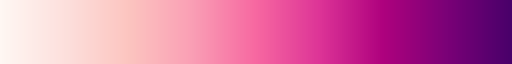

In [23]:
cmap = mpl.colormaps['RdPu']
cmap

/tmp/ipykernel_666148/775122536.py:1: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


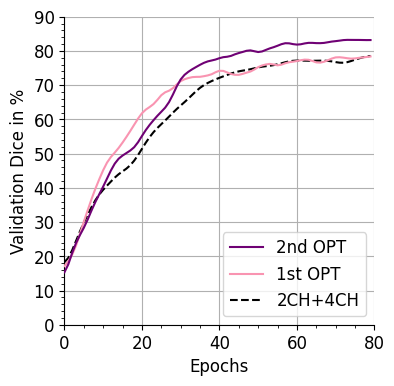

In [24]:
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib as mpl

font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 12}

mpl.rc('font', **font)

ref_smoothed = gaussian_filter1d(df['20240201__16_29_09_sleek-design_fold-1_stage-ref - scores/val_mean_oa_exclude_bg_dice']*100, sigma=2)
opt_first_smoothed = gaussian_filter1d(df['20240201__16_29_09_sleek-design_fold-1_stage-opt_first - scores/val_mean_oa_exclude_bg_dice']*100, sigma=1.2)
opt_second_smoothed = gaussian_filter1d(df['20240201__16_29_09_sleek-design_fold-1_stage-opt_second - scores/val_mean_oa_exclude_bg_dice']*100, sigma=1.2)
opt_both_fix_smoothed = gaussian_filter1d(df['20240201__16_29_09_sleek-design_fold-1_stage-opt_both_fix - scores/val_mean_oa_exclude_bg_dice']*100, sigma=1.2)

LW = 1.5
plt.figure(figsize=(4,4))
# plt.plot(opt_both_fix_smoothed, c=cmap(.9), label='VIEWS FIX', linewidth=LW, zorder=30)
plt.plot(opt_second_smoothed, c=cmap(.9), label='2nd OPT', linewidth=LW, zorder=20)
plt.plot(opt_first_smoothed, c=cmap(.4), label='1st OPT', linewidth=LW, zorder=10)
plt.plot(ref_smoothed, 'k--',label='2CH+4CH', linewidth=LW)
plt.grid(which='major')
plt.minorticks_on()
# turn outer lines off
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Validation Dice in %')
plt.xlim([0, 80])
plt.ylim([0, 90])

plt.savefig('mmwhs_stage_dices.pdf', bbox_inches='tight')

# from scipy.interpolate import BSpline, make_interp_spline
# import numpy as np

# plt.plot(ref_smoothed, c='k', label='ref')
# # plt.show()

# # plt.plot(get_spline_of_data(df['20240201__16_29_09_sleek-design_fold-1_stage-ref - scores/val_mean_oa_exclude_bg_dice']*100))
# # plt.show()

# Related works experiment

In [245]:
def get_wanted_keys_binary(phase):
    assert phase in ['val', 'test']

    wanted_keys = {
        '_id': '_id',
        'prescan_res': 'Scout res.',
        'prescan_type': 'Scout label',
        'slice_res': 'Slice res.',
        'slice_type': 'Slice label',
        'first_view': '1st view',
        'second_view': '2nd view',
        'fold': 'fold',
        'model_type': 'Model',

        f'scores/{phase}_mean_oa_exclude_bg_hd95': '\multicolumn{1}{c}{$\mu\pm\sigma$  }',
        f'scores/{phase}_std_oa_exclude_bg_hd95': 'N/A',

        f'scores/{phase}_mean_oa_exclude_bg_dice': '\multicolumn{1}{c}{$\mu\pm\sigma$ }',
        f'scores/{phase}_std_oa_exclude_bg_dice': 'N/A',

    }

    return wanted_keys

# MMWHS

In [246]:
recent_mmwhs_binary_runs = list(filter(lambda r:
                          r.name.startswith("202403")
                          and 'meta_config_id' in r.config
                          and isinstance(r.config['meta_config_id'], int)
                          and r.config['dataset'][0] == 'mmwhs', runs))

mmwhs_binary_runs = [dict(name=f"dummy{idx:02d}") for idx in range(0,18)]

for meta_config_id in range(20,26):
    for fold_idx in range(0,3):
        wandb_runs = list(filter(lambda r: f"fold-{fold_idx}" in r.name
            and 'meta_config_id' in r.config
            and r.config['meta_config_id'] == meta_config_id
            and '-ref' in r.name,
            recent_mmwhs_binary_runs))

        if len(wandb_runs) > 1:
            raise ValueError(f"Expected exactly one run, got {len(wandb_runs)}")
        elif len(wandb_runs) == 0:
            continue

        run = wandb_runs[0]
        name = run.name
        path = run.path
        meta_config_id = run.config['meta_config_id']

        fold_idx = int(re.match(r'.*fold-(\d+).*', name).group(1))
        entry = dict(
            name=name,
            id=meta_config_id,
            fold=fold_idx,
            access_key='/'.join(path),
        )
        mmwhs_binary_runs[(meta_config_id-20)*3+fold_idx] = entry

with open('mmwhs_binary_runs.json', 'w') as f:
    json.dump(mmwhs_binary_runs, f, indent=4)

In [247]:
PHASE = 'val'
VALUE_SELECTOR = 'select_last'

df_binary = pd.DataFrame()

for run_idx, rr in enumerate(mmwhs_binary_runs):
   wandb_run_name = rr['name']
   run_frame = pd.DataFrame()
   run_numeric_id = run_idx // 3
   try:
      run_key = rr['access_key']
      wrun = api.run(run_key)
      run_frame = pd.DataFrame(wrun.history())
      if VALUE_SELECTOR == 'select_best':
         max_idx = run_frame[f'scores/{PHASE}_mean_oa_exclude_bg_dice'].idxmax()
         run_frame = run_frame.fillna(method='ffill')
         run_frame = run_frame.iloc[max_idx:max_idx+1]
      elif VALUE_SELECTOR == 'select_last':
         run_frame = run_frame.iloc[-1:]
      else:
         raise ValueError()

      run_frame.index = [run_idx]

   except:
      print(f"Failed to fetch run {wandb_run_name}")
      run_frame = run_frame.map(lambda x: np.nan)

   run_frame.insert(0, '_id', [run_numeric_id])
   run_frame.insert(1, 'first_view', 'SA' if 'SA' in wrun.config['sa_view'] else wrun.config['sa_view'])
   run_frame.insert(2, 'second_view', 'SA' if 'SA' in wrun.config['hla_view'] else wrun.config['hla_view'])
   run_frame.insert(3, 'prescan_res', "$(1.5mm)^3$")
   run_frame.insert(4, 'prescan_type', "GT")
   run_frame.insert(5, 'slice_res', "$(1.5mm)^2$")
   run_frame.insert(6, 'slice_type', "GT")
   fold_idx = run_idx % 3
   run_frame.insert(8, 'fold', fold_idx)
   run_frame.insert(9, 'model_type', wrun.config['model_type'])

   df_binary = pd.concat([df_binary,run_frame])

df_binary = df_binary.fillna(0)

In [248]:
filtered_frame = df_binary.copy()
FIRST_FOLD_ONLY = False
if FIRST_FOLD_ONLY:
    filtered_frame = filtered_frame[filtered_frame['fold'] == 0]
else:
    filtered_frame = filtered_frame.groupby('_id').agg(get_agg_dict(filtered_frame))

# Prepare values
wanted_keys = get_wanted_keys_binary('val')
filtered_frame = filtered_frame[wanted_keys.keys()]
filtered_frame

,_id,prescan_res,prescan_type,slice_res,slice_type,first_view,second_view,fold,model_type,scores/val_mean_oa_exclude_bg_hd95,scores/val_std_oa_exclude_bg_hd95,scores/val_mean_oa_exclude_bg_dice,scores/val_std_oa_exclude_bg_dice
_id,,,,,,,,,,,,,
0,0,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,p2CH,p4CH,0,hybrid-unet,19.974838,6.424397,0.864072,0.040582
1,1,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,p2CH,p4CH,0,hybrid-EPix2Vox,22.085768,7.233135,0.800353,0.077971
2,2,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,2CH,4CH,0,hybrid-unet,18.112604,6.477501,0.875757,0.034912
3,3,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,2CH,4CH,0,hybrid-EPix2Vox,22.100542,8.380290,0.815237,0.072485
4,4,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,2CH,SA,0,hybrid-unet,23.734836,6.721230,0.854047,0.045174
5,5,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,2CH,SA,0,hybrid-EPix2Vox,20.819185,8.097480,0.833127,0.052455


In [249]:
percent_keys = [k for k in wanted_keys if "dice" in k or "vol_rel" in k]
mean_keys = [k for k in wanted_keys if "mean" in k]
min_metrics_keys = [k for k in wanted_keys if ("delta" in k or "hd" in k) and not 'std' in k]
max_metrics_keys = [k for k in wanted_keys if ("dice" in k or "iou" in k) and not 'std' in k]
filtered_frame.loc[:,percent_keys] *= 100.
filtered_frame.index = list(range(len(filtered_frame)))

filtered_frame

,_id,prescan_res,prescan_type,slice_res,slice_type,first_view,second_view,fold,model_type,scores/val_mean_oa_exclude_bg_hd95,scores/val_std_oa_exclude_bg_hd95,scores/val_mean_oa_exclude_bg_dice,scores/val_std_oa_exclude_bg_dice
0,0,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,p2CH,p4CH,0,hybrid-unet,19.974838,6.424397,86.407160,4.058170
1,1,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,p2CH,p4CH,0,hybrid-EPix2Vox,22.085768,7.233135,80.035255,7.797101
2,2,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,2CH,4CH,0,hybrid-unet,18.112604,6.477501,87.575727,3.491206
3,3,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,2CH,4CH,0,hybrid-EPix2Vox,22.100542,8.380290,81.523676,7.248501
4,4,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,2CH,SA,0,hybrid-unet,23.734836,6.721230,85.404730,4.517373
5,5,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,2CH,SA,0,hybrid-EPix2Vox,20.819185,8.097480,83.312682,5.245484


In [250]:
# Get bold values (best)
group_ranges = [
    # [0,6]
    [0,2],
    [2,4],
    [4,6],
]

bold_idxs = []
for sub_range in group_ranges:
    sub_frame = filtered_frame.iloc[sub_range[0]:sub_range[1]]
    optimal_vals_maximize = sub_frame[max_metrics_keys].idxmax()
    optimal_vals_minimize = sub_frame[min_metrics_keys].idxmin()

    bold_idxs.append(optimal_vals_maximize)
    bold_idxs.append(optimal_vals_minimize)

In [251]:
# Round and convert
filtered_frame = filtered_frame.round(decimals=1)
string_frame = filtered_frame.copy().astype(str)

# Fuse mean and std columns
for m in mean_keys:
    mean_col = string_frame[m].astype(str)
    std_col_key = m.replace("mean","std")
    if std_col_key in string_frame.columns:
        std_col = string_frame[std_col_key].astype(str)
        string_frame[m] = mean_col + r" \pm " + std_col
        string_frame.drop(std_col_key, axis=1, inplace=True)

# Add bold to optimal values
for bold_group in bold_idxs:
    for col_name, idx in zip(bold_group.index, bold_group.values):
        row_idx = string_frame.index.get_loc(idx)
        col_idx = string_frame.columns.get_loc(col_name)
        string_frame.iloc[row_idx,col_idx] = r"\B " + string_frame.iloc[row_idx,col_idx]

# Replace column names
string_frame.columns = [wanted_keys[c] for c in string_frame.columns]

# Drop and insert spacer columns
string_frame.drop('_id', axis=1, inplace=True)
string_frame.drop('fold', axis=1, inplace=True)

# string_frame.insert(0, 'Type of: scout --- slices', new_rows_descriptors)
string_frame = string_frame.drop(["Scout res.", "Scout label", "Slice res.", "Slice label"], axis=1)

# Flip group rows
for grp_rng in group_ranges:
    string_frame.iloc[grp_rng[0]], string_frame.iloc[grp_rng[1]-1] = \
        string_frame.iloc[grp_rng[1]-1], string_frame.iloc[grp_rng[0]]

# Add multirows
for grp_rng in group_ranges:
    for col_idx in range(2):
        first_row_text = string_frame.iloc[grp_rng[0],col_idx]
        string_frame.iloc[grp_rng[0],col_idx] ='\multirow{2}{*}{' + first_row_text + '}'
        string_frame.iloc[grp_rng[1]-1,col_idx] = ''


# Replace model names
string_frame['Model'] = string_frame['Model'].str.replace('hybrid-unet','Ours')
string_frame['Model'] = string_frame['Model'].str.replace(r'hybrid-EPix2Vox','EP2V \cite{stojanovski2022efficient}')

string_frame

,1st view,2nd view,Model,\multicolumn{1}{c}{$\mu\pm\sigma$ },\multicolumn{1}{c}{$\mu\pm\sigma$ }
0,\multirow{2}{*}{p2CH},\multirow{2}{*}{p4CH},EP2V \cite{stojanovski2022efficient},22.1 \pm 7.2,80.0 \pm 7.8
1,,,Ours,\B 20.0 \pm 6.4,\B 86.4 \pm 4.1
2,\multirow{2}{*}{2CH},\multirow{2}{*}{4CH},EP2V \cite{stojanovski2022efficient},22.1 \pm 8.4,81.5 \pm 7.2
3,,,Ours,\B 18.1 \pm 6.5,\B 87.6 \pm 3.5
4,\multirow{2}{*}{2CH},\multirow{2}{*}{SA},EP2V \cite{stojanovski2022efficient},\B 20.8 \pm 8.1,83.3 \pm 5.2
5,,,Ours,23.7 \pm 6.7,\B 85.4 \pm 4.5


In [252]:
# Save to latex

PM_COL_FORMAT = "S[table-figures-decimal=1,separate-uncertainty=true,table-format=3.1(3)]"

COL_FORMAT = \
    ("c" * 3) \
    + PM_COL_FORMAT \
    + ("c" * 0) \
    + PM_COL_FORMAT \
# 5 cols

header = [
    r'\multicolumn{3}{l}{\textbf{Clinically acq. MMWHS data}}'] \
    + [r'\multicolumn{1}{c}{\textbf{HD95 in mm $\downarrow$}}'] + 1*[None] \
    + [r'\multicolumn{1}{c}{\textbf{Dice in \% $\uparrow$}}'] + 1*[None] \


latex_frame = pd.concat([pd.DataFrame(header, index=string_frame.columns).T, string_frame])

latex_frame.to_latex(
    buf="mmwhs_binary_results.txt",
    escape=False,
    column_format=COL_FORMAT,
    index=False,
)

# Load latex file and replace & NaN with &
with open("mmwhs_binary_results.txt", "r") as f:
    lines = f.readlines()
    lines = [l.replace("Scout res. & Scout label", r'\multicolumn{2}{c}{Scout res./label}') for l in lines]
    lines = [l.replace("Slice res. & Slice label", r'\multicolumn{2}{c}{Slice res./label}') for l in lines]
    lines = [l.replace("& NaN", "") for l in lines]

with open("mmwhs_binary_results.txt", "w") as f:
    f.writelines(lines)

# Insert 5th line before third line
with open("mmwhs_binary_results.txt", "r") as f:
    lines = f.readlines()
    lines.insert(2, lines[4])
    del lines[5]
    for ln_idx in [6,8]:
        lines[ln_idx] = lines[ln_idx].replace(r'\\', r'\\\noalign{\vskip 1.0ex}')

with open("mmwhs_binary_results.txt", "w") as f:
    f.writelines(lines)

# MRXCAT

In [253]:
recent_mmwhs_binary_runs = list(filter(lambda r:
                          r.name.startswith("202403")
                          and 'meta_config_id' in r.config
                          and isinstance(r.config['meta_config_id'], int)
                          and r.config['dataset'][0] == 'mrxcat', runs))

mmwhs_binary_runs = [dict(name=f"dummy{idx:02d}") for idx in range(0,18)]

for meta_config_id in range(20,26):
    for fold_idx in range(0,3):
        # if meta_config_id in [9,11,13,15]:
        #     wandb_runs = list(filter(lambda r: f"fold-{fold_idx}" in r.name
        #         and 'meta_config_id' in r.config
        #         and r.config['meta_config_id'] == meta_config_id
        #         and '-opt_both_fix' in r.name,
        #         recent_mmwhs_runs))
        # else:
        wandb_runs = list(filter(lambda r: f"fold-{fold_idx}" in r.name
            and 'meta_config_id' in r.config
            and r.config['meta_config_id'] == meta_config_id
            and '-ref' in r.name,
            recent_mmwhs_binary_runs))

        if len(wandb_runs) > 1:
            raise ValueError(f"Expected exactly one run, got {len(wandb_runs)}")
        elif len(wandb_runs) == 0:
            continue

        run = wandb_runs[0]
        name = run.name
        path = run.path
        meta_config_id = run.config['meta_config_id']

        fold_idx = int(re.match(r'.*fold-(\d+).*', name).group(1))
        entry = dict(
            name=name,
            id=meta_config_id,
            fold=fold_idx,
            access_key='/'.join(path),
        )
        mmwhs_binary_runs[(meta_config_id-20)*3+fold_idx] = entry

with open('mrxcat_binary_runs.json', 'w') as f:
    json.dump(mmwhs_binary_runs, f, indent=4)

In [254]:
PHASE = 'test'
VALUE_SELECTOR = 'select_last'

df_binary = pd.DataFrame()

for run_idx, rr in enumerate(mmwhs_binary_runs):
   wandb_run_name = rr['name']
   run_frame = pd.DataFrame()
   run_numeric_id = run_idx // 3
   try:
      run_key = rr['access_key']
      wrun = api.run(run_key)
      run_frame = pd.DataFrame(wrun.history())
      if VALUE_SELECTOR == 'select_best':
         max_idx = run_frame[f'scores/{PHASE}_mean_oa_exclude_bg_dice'].idxmax()
         run_frame = run_frame.fillna(method='ffill')
         run_frame = run_frame.iloc[max_idx:max_idx+1]
      elif VALUE_SELECTOR == 'select_last':
         run_frame = run_frame.iloc[-1:]
      else:
         raise ValueError()

      run_frame.index = [run_idx]

   except:
      print(f"Failed to fetch run {wandb_run_name}")
      run_frame = run_frame.map(lambda x: np.nan)

   run_frame.insert(0, '_id', [run_numeric_id])
   run_frame.insert(1, 'first_view', 'SA' if 'SA' in wrun.config['sa_view'] else wrun.config['sa_view'])
   run_frame.insert(2, 'second_view', 'SA' if 'SA' in wrun.config['hla_view'] else wrun.config['hla_view'])
   run_frame.insert(3, 'prescan_res', "$(1.5mm)^3$")
   run_frame.insert(4, 'prescan_type', "GT")
   run_frame.insert(5, 'slice_res', "$(1.5mm)^2$")
   run_frame.insert(6, 'slice_type', "GT")
   fold_idx = run_idx % 3
   run_frame.insert(8, 'fold', fold_idx)
   run_frame.insert(9, 'model_type', wrun.config['model_type'])

   df_binary = pd.concat([df_binary,run_frame])

df_binary = df_binary.fillna(0)

In [255]:
filtered_frame = df_binary.copy()
FIRST_FOLD_ONLY = False
if FIRST_FOLD_ONLY:
    filtered_frame = filtered_frame[filtered_frame['fold'] == 0]
else:
    filtered_frame = filtered_frame.groupby('_id').agg(get_agg_dict(filtered_frame))

# Prepare values
wanted_keys = get_wanted_keys_binary('val')
filtered_frame = filtered_frame[wanted_keys.keys()]
# filtered_frame = filtered_frame.sort_values(['_id', 'model_type'], ascending=[False, True])
filtered_frame

,_id,prescan_res,prescan_type,slice_res,slice_type,first_view,second_view,fold,model_type,scores/val_mean_oa_exclude_bg_hd95,scores/val_std_oa_exclude_bg_hd95,scores/val_mean_oa_exclude_bg_dice,scores/val_std_oa_exclude_bg_dice
_id,,,,,,,,,,,,,
0,0,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,p2CH,p4CH,0,hybrid-unet,4.665099,1.739462,0.965805,0.013843
1,1,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,p2CH,p4CH,0,hybrid-EPix2Vox,7.152856,4.630444,0.942622,0.044765
2,2,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,2CH,4CH,0,hybrid-unet,5.160337,2.839609,0.958982,0.021836
3,3,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,2CH,4CH,0,hybrid-EPix2Vox,5.562641,2.445531,0.962247,0.021005
4,4,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,2CH,SA,0,hybrid-unet,4.274837,2.445874,0.963687,0.023612
5,5,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,2CH,SA,0,hybrid-EPix2Vox,6.209476,4.543344,0.951069,0.047578


In [256]:
percent_keys = [k for k in wanted_keys if "dice" in k or "vol_rel" in k]
mean_keys = [k for k in wanted_keys if "mean" in k]
min_metrics_keys = [k for k in wanted_keys if ("delta" in k or "hd" in k) and not 'std' in k]
max_metrics_keys = [k for k in wanted_keys if ("dice" in k or "iou" in k) and not 'std' in k]
filtered_frame.loc[:,percent_keys] *= 100.
filtered_frame.index = list(range(len(filtered_frame)))

filtered_frame

,_id,prescan_res,prescan_type,slice_res,slice_type,first_view,second_view,fold,model_type,scores/val_mean_oa_exclude_bg_hd95,scores/val_std_oa_exclude_bg_hd95,scores/val_mean_oa_exclude_bg_dice,scores/val_std_oa_exclude_bg_dice
0,0,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,p2CH,p4CH,0,hybrid-unet,4.665099,1.739462,96.580506,1.384310
1,1,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,p2CH,p4CH,0,hybrid-EPix2Vox,7.152856,4.630444,94.262238,4.476454
2,2,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,2CH,4CH,0,hybrid-unet,5.160337,2.839609,95.898172,2.183605
3,3,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,2CH,4CH,0,hybrid-EPix2Vox,5.562641,2.445531,96.224722,2.100470
4,4,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,2CH,SA,0,hybrid-unet,4.274837,2.445874,96.368687,2.361195
5,5,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,2CH,SA,0,hybrid-EPix2Vox,6.209476,4.543344,95.106862,4.757818


In [257]:
# Get bold values (best)
group_ranges = [
    # [0,6]
    [0,2],
    [2,4],
    [4,6],
]

bold_idxs = []
for sub_range in group_ranges:
    sub_frame = filtered_frame.iloc[sub_range[0]:sub_range[1]]
    optimal_vals_maximize = sub_frame[max_metrics_keys].idxmax()
    optimal_vals_minimize = sub_frame[min_metrics_keys].idxmin()

    bold_idxs.append(optimal_vals_maximize)
    bold_idxs.append(optimal_vals_minimize)

In [258]:
# Round and convert
filtered_frame = filtered_frame.round(decimals=1)
string_frame = filtered_frame.copy().astype(str)

# Fuse mean and std columns
for m in mean_keys:
    mean_col = string_frame[m].astype(str)
    std_col_key = m.replace("mean","std")
    if std_col_key in string_frame.columns:
        std_col = string_frame[std_col_key].astype(str)
        string_frame[m] = mean_col + r" \pm " + std_col
        string_frame.drop(std_col_key, axis=1, inplace=True)

# Add bold to optimal values
for bold_group in bold_idxs:
    for col_name, idx in zip(bold_group.index, bold_group.values):
        row_idx = string_frame.index.get_loc(idx)
        col_idx = string_frame.columns.get_loc(col_name)
        string_frame.iloc[row_idx,col_idx] = r"\B " + string_frame.iloc[row_idx,col_idx]


# Replace column names
string_frame.columns = [wanted_keys[c] for c in string_frame.columns]

# Drop and insert spacer columns
string_frame.drop('fold', axis=1, inplace=True)
string_frame.drop('_id', axis=1, inplace=True)

# string_frame.insert(0, 'Type of: scout --- slices', new_rows_descriptors)
string_frame = string_frame.drop(["Scout res.", "Scout label", "Slice res.", "Slice label"], axis=1)

# Flip group rows
for grp_rng in group_ranges:
    string_frame.iloc[grp_rng[0]], string_frame.iloc[grp_rng[1]-1] = \
        string_frame.iloc[grp_rng[1]-1], string_frame.iloc[grp_rng[0]]

# Add multirows
for grp_rng in group_ranges:
    for col_idx in range(2):
        first_row_text = string_frame.iloc[grp_rng[0],col_idx]
        string_frame.iloc[grp_rng[0],col_idx] ='\multirow{2}{*}{' + first_row_text + '}'
        string_frame.iloc[grp_rng[1]-1,col_idx] = ''

# Replace model names
string_frame['Model'] = string_frame['Model'].str.replace('hybrid-unet','Ours')
string_frame['Model'] = string_frame['Model'].str.replace(r'hybrid-EPix2Vox','EP2V \cite{stojanovski2022efficient}')

string_frame

,1st view,2nd view,Model,\multicolumn{1}{c}{$\mu\pm\sigma$ },\multicolumn{1}{c}{$\mu\pm\sigma$ }
0,\multirow{2}{*}{p2CH},\multirow{2}{*}{p4CH},EP2V \cite{stojanovski2022efficient},7.2 \pm 4.6,94.3 \pm 4.5
1,,,Ours,\B 4.7 \pm 1.7,\B 96.6 \pm 1.4
2,\multirow{2}{*}{2CH},\multirow{2}{*}{4CH},EP2V \cite{stojanovski2022efficient},5.6 \pm 2.4,\B 96.2 \pm 2.1
3,,,Ours,\B 5.2 \pm 2.8,95.9 \pm 2.2
4,\multirow{2}{*}{2CH},\multirow{2}{*}{SA},EP2V \cite{stojanovski2022efficient},6.2 \pm 4.5,95.1 \pm 4.8
5,,,Ours,\B 4.3 \pm 2.4,\B 96.4 \pm 2.4


In [259]:
# Save to latex

PM_COL_FORMAT = "S[table-figures-decimal=1,separate-uncertainty=true,table-format=3.1(3)]"

COL_FORMAT = \
    ("c" * 3) \
    + PM_COL_FORMAT \
    + ("c" * 0) \
    + PM_COL_FORMAT \
# 5 cols

header = [
    r'\multicolumn{3}{l}{\textbf{Synthetic cine MRXCAT data}}'] \
    + [r'\multicolumn{1}{c}{\textbf{HD95 in mm $\downarrow$}}'] + 1*[None] \
    + [r'\multicolumn{1}{c}{\textbf{Dice in \% $\uparrow$}}'] + 1*[None] \


latex_frame = pd.concat([pd.DataFrame(header, index=string_frame.columns).T, string_frame])

latex_frame.to_latex(
    buf="mrxcat_binary_results.txt",
    escape=False,
    column_format=COL_FORMAT,
    index=False,
)

# Load latex file and replace & NaN with &
with open("mrxcat_binary_results.txt", "r") as f:
    lines = f.readlines()
    lines = [l.replace("Scout res. & Scout label", r'\multicolumn{2}{c}{Scout res./label}') for l in lines]
    lines = [l.replace("Slice res. & Slice label", r'\multicolumn{2}{c}{Slice res./label}') for l in lines]
    lines = [l.replace("& NaN", "") for l in lines]

with open("mrxcat_binary_results.txt", "w") as f:
    f.writelines(lines)

# Insert 5th line before third line
with open("mrxcat_binary_results.txt", "r") as f:
    lines = f.readlines()
    lines.insert(2, lines[4])
    del lines[5]
    for ln_idx in [6,8]:
        lines[ln_idx] = lines[ln_idx].replace(r'\\', r'\\\noalign{\vskip 1.0ex}')

with open("mrxcat_binary_results.txt", "w") as f:
    f.writelines(lines)